In [2]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.typing import NDArray

np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [3]:
# --- Anything that uses this function in unnecessarily obfuscated
# def append_ones(matrix):
#     return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=1)


def zeros(*dims: int) -> NDArray:
    return np.zeros(shape=tuple(dims), dtype=np.float32)


def ones(*dims: int) -> NDArray:
    return np.ones(shape=tuple(dims), dtype=np.float32)


def rand(*dims: int) -> NDArray:
    return np.random.rand(*dims).astype(np.float32)


def chunks(seq: NDArray, size: int):
    return (seq[pos : pos + size] for pos in range(0, len(seq), size))


def tiles(examples: NDArray) -> NDArray:
    rows, cols, h, w = examples.shape
    space = 2

    img_matrix = np.empty(shape=(rows * h + (rows - 1) * space, cols * w + (cols - 1) * space))
    img_matrix.fill(np.nan)

    for r in range(rows):
        for c in range(cols):
            x0 = r * w + r * space
            y0 = c * h + c * space
            img_matrix[x0 : x0 + w, y0 : y0 + w] = examples[r, c, :, :]

    plt.matshow(img_matrix, cmap="gray", interpolation="none")
    plt.axis("off")
    plt.show()

# MNIST dataset

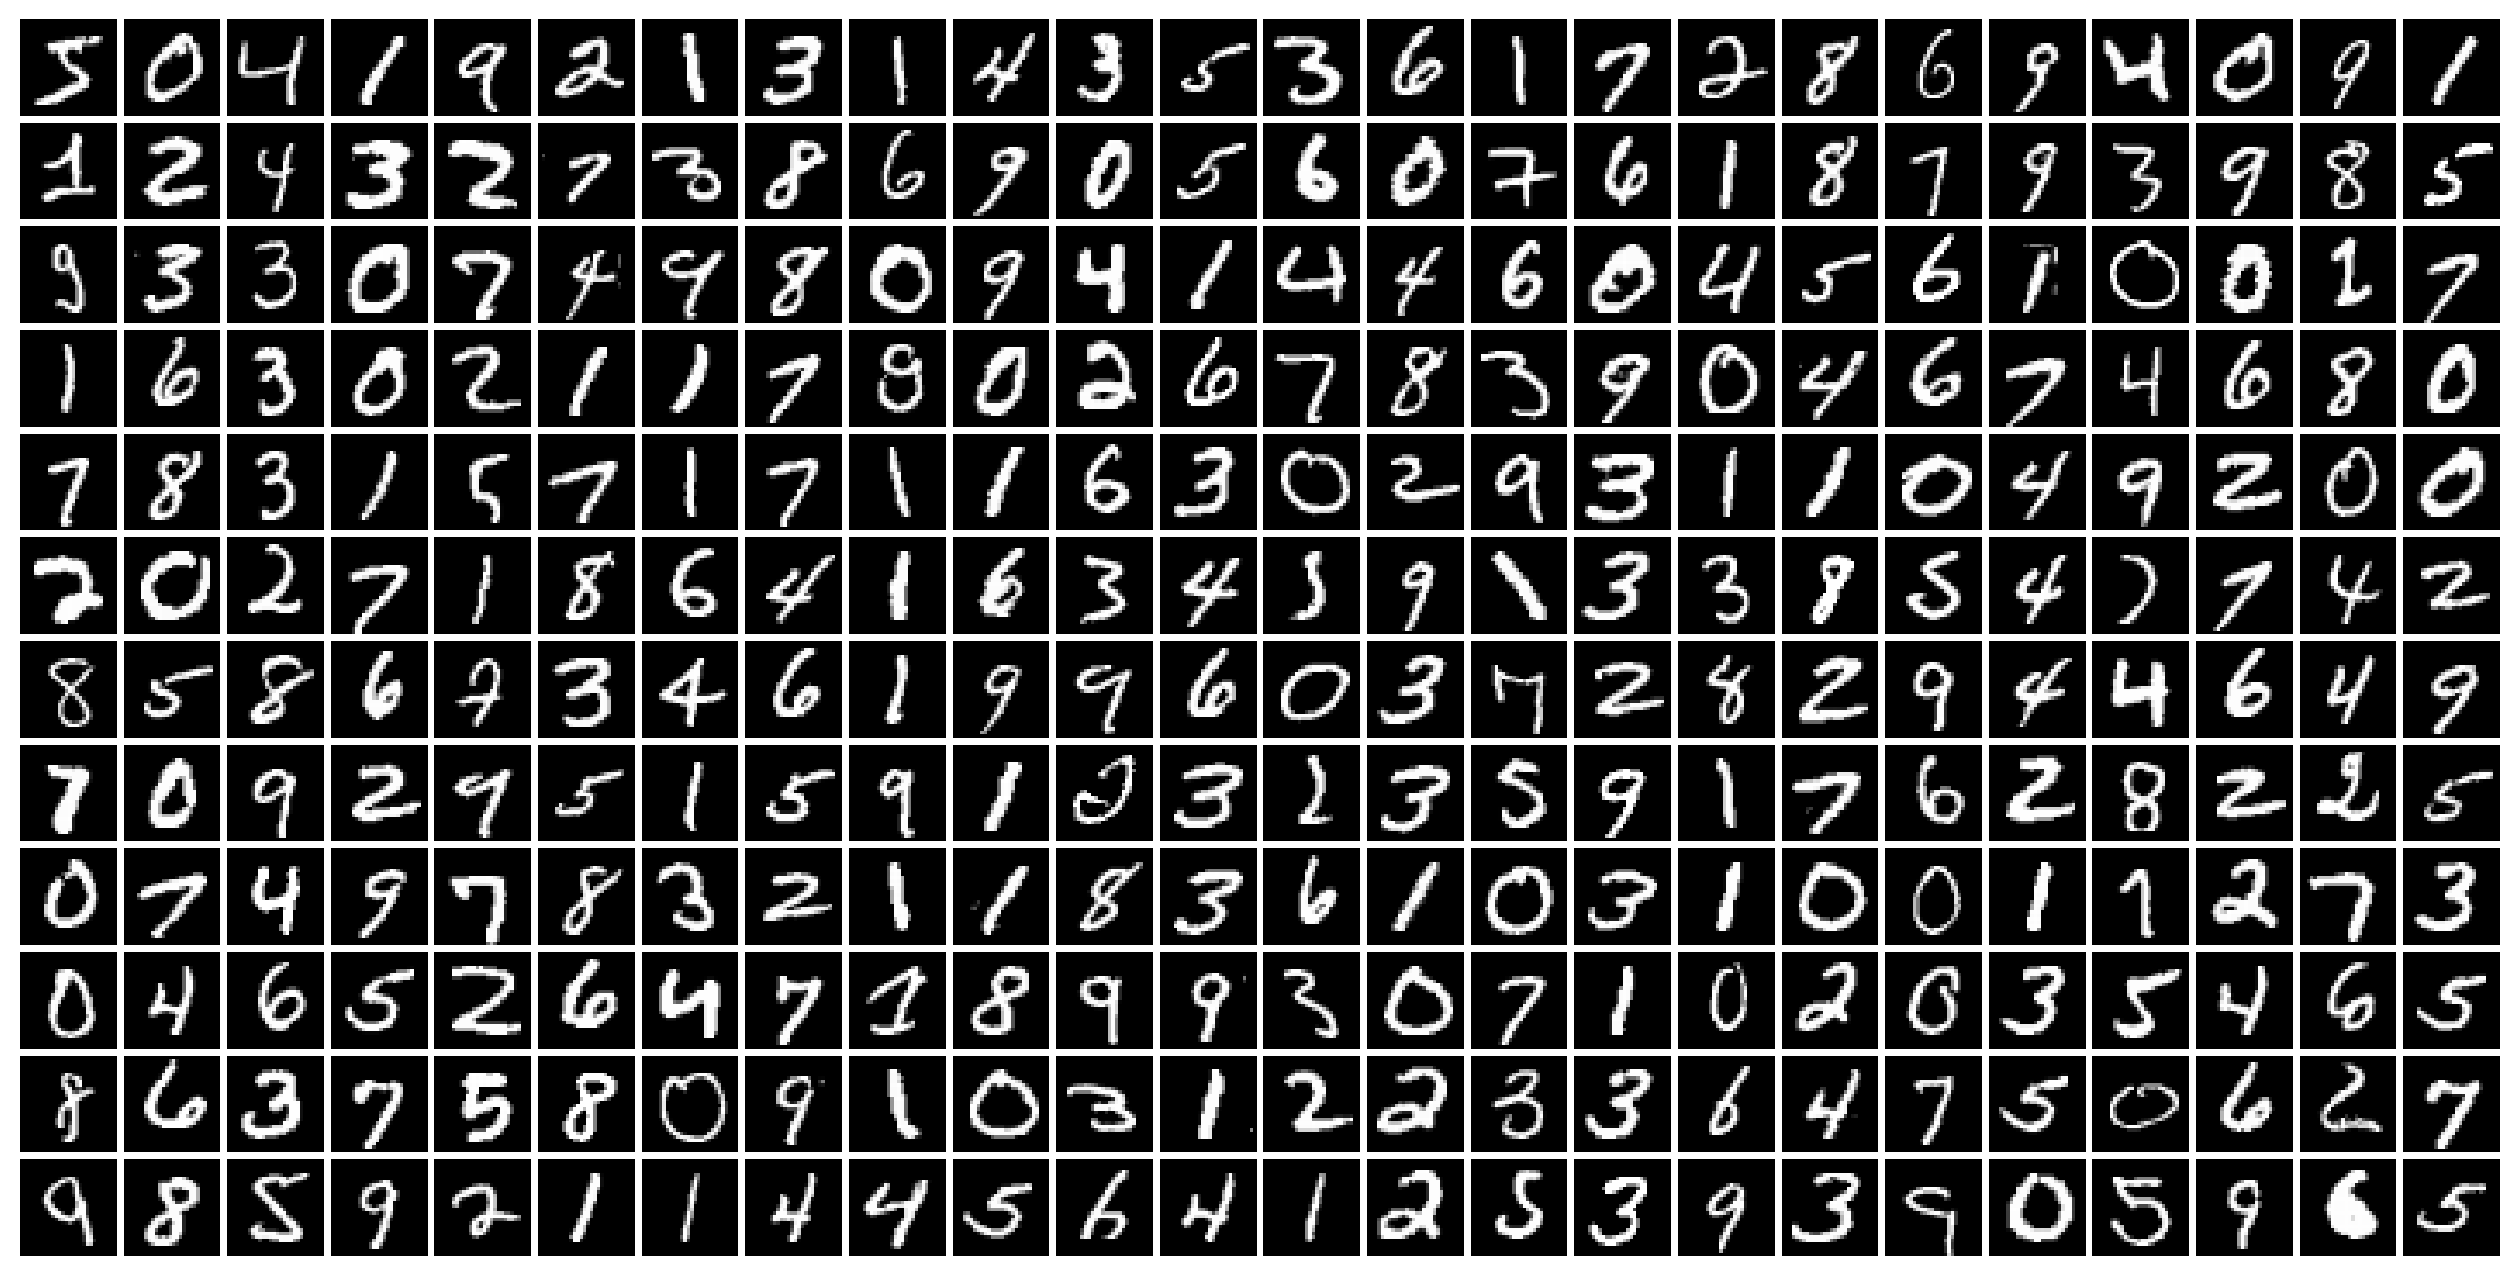

In [4]:
from mnists import MNIST

mnist = MNIST()
digits = mnist.train_images()
digits = digits[: 12 * 24]
digits = digits.reshape(12, 24, 28, 28)
tiles(digits)

# Restricted Boltzmann Machine & Contrastive Divergence algorithm

In [5]:
def sigmoid(X: NDArray) -> NDArray:
    return 1.0 / (1.0 + np.exp(-X))


class RBM:
    def __init__(self, vsize: int, hsize: int, lr: float):
        self.vsize, self.hsize = vsize, hsize
        self.lr = lr
        self.reset()

    def reset(self):
        # Xavier initialization
        radius = np.sqrt(6 / (self.vsize + self.hsize))
        self.w = np.random.uniform(-radius, +radius, size=(self.vsize, self.hsize)).astype(np.float32)

        # Zero initialization
        self.b = np.zeros(self.vsize).astype(np.float32)
        self.c = np.zeros(self.hsize).astype(np.float32)

    def probas_v(self, h: NDArray) -> NDArray:
        return sigmoid(self.b + h @ self.w.T)

    def probas_h(self, v: NDArray) -> NDArray:
        return sigmoid(self.c + v @ self.w)

    def sample(self, v: NDArray, k: int) -> NDArray:
        batch_size = v.shape[0]
        # --- Gibbs sampling
        for _ in range(k):
            h = self.probas_h(v) > rand(batch_size, self.hsize)
            σ = self.probas_v(h)
            v = σ > rand(batch_size, self.vsize)

        return σ

## Algorytm Contrastive Divergence

$\newcommand{\vect}[1]{\mathbf{#1}}$
W sieci RBM gradient funkcji kosztu względem wag wyznaczamy zgodnie ze wzorem:

$\frac{\delta}{\delta w_{ij}} -\log P(\vect{v}) = -\mathbf{E}[v_i h_j \vert \vect{v}] + \mathbf{E}[v_i h_j]$

#### Faza pozytywna - odpowiada za część $\mathbf{E}[v_i h_j \vert \vect{v}]$

Tą część gradientu wyznaczamy przez wyliczenie iloczynów $v_i h_j$ pomiędzy elementami wektora obserwacji ($v_i$) a prawdopodobieństwami aktywacji w warstwie ukrytej ($h_j$). Operację tą możemy zapisać w postaci zwektoryzowanej jako:

$\nabla_P = \vect{v}^T\sigma(\vect{vW})$

#### Faza negatywna - odpowiada za część $\mathbf{E}[v_i h_j]$

Rozpoczynamy od prawdopodobieństw aktywacji neuronów w warstwie ukrytej, które zostały wyznaczone w fazie pozytywnej. Na ich podstawie losujemy próbkę aktywacji w warstwie ukrytej:

$\vect{h} = \sigma (\vect{vW}) > [rand_1, rand_2, \dots, rand_m]$

Następnie losujemy próbkę aktywacji w warstwie widocznej:

$\vect{v}_1 = \sigma (\vect{hW}^T) > [rand_1, rand_2, \dots, rand_n]$

Aby wyznaczyć *fantazję* sieci RBM, powyższe próbki losujemy (naprzemiennie) $k$ razy (gdzie $k$ to parametr algorytmu CD-*k*):

$\vect{h}_{k-1} = \sigma (\vect{v}_{k-1}\vect{W}) > [rand_1, rand_2, \dots, rand_m]$, 
$\vect{v}_k = \sigma (\vect{h}_{k-1}\vect{W}^T) > [rand_1, rand_2, \dots, rand_n]$

Część negatywną gradientu wyznaczamy poprzez wyliczenie iloczynów $v_{k_i} h_j$ pomiędzy elementami wektora *fantazji* RBM ($v_{k_i}$) a prawdopodobieństwami aktywacji w warstwie ukrytej wyliczonymi dla tejże *fantazji* ($h_j$). Operację tą możemy zapisać w postaci zwektoryzowanej jako:

$\nabla_N = \vect{v}_k^T\sigma(\vect{v}_k\vect{W})$


#### Aktualizacja macierzy wag RBM

Uczymy stochastycznym spadkiem wzdłuż gradientu:

$\phi_{t+1} \leftarrow \phi_t - \epsilon \nabla$

co dla gradientu RBM daje:

$W_{t+1} \leftarrow W_t + \epsilon \nabla_P - \epsilon \nabla_N$

In [6]:
def cdk(rbm: RBM, minibatch: NDArray, k: int = 1):
    batch_size = minibatch.shape[0]
    v = minibatch

    # Compute gradients
    # -----------------
    # Positive phase

    σ = rbm.probas_h(v)

    grad_pw = 1 / batch_size * (v.T @ σ)
    grad_pb = 1 / batch_size * v.sum(axis=0)
    grad_pc = 1 / batch_size * σ.sum(axis=0)

    # Negative phase

    # --- Gibbs sampling
    h = σ > rand(batch_size, rbm.hsize)
    v = rbm.probas_v(h) > rand(batch_size, rbm.vsize)
    for _ in range(k - 1):
        h = rbm.probas_h(v) > rand(batch_size, rbm.hsize)
        v = rbm.probas_v(h) > rand(batch_size, rbm.vsize)

    # --- Negative gradient estimation
    σ = rbm.probas_h(v)

    grad_nw = 1 / batch_size * (v.T @ σ)
    grad_nb = 1 / batch_size * (v.sum(axis=0))
    grad_nc = 1 / batch_size * (σ.sum(axis=0))

    # Update params
    # -------------
    rbm.w += rbm.lr * (grad_pw - grad_nw)
    rbm.b += rbm.lr * (grad_pb - grad_nb)
    rbm.c += rbm.lr * (grad_pc - grad_nc)

### RBM reconstruction error

In [7]:
def reconstuction_error(rbm: RBM, v: NDArray) -> float:
    batch_size = v.shape[0]
    h = rbm.probas_h(v) > rand(batch_size, rbm.hsize)
    σ = rbm.probas_v(h)
    return 1 / batch_size * np.sum((v - σ) ** 2)

# RBM Training

In [8]:
import time

DATASET_SIZE = 20_000  # 60000 for whole dataset
DIGIT_SIZE = 28

VISIBLE_LAYER_SIZE = DIGIT_SIZE * DIGIT_SIZE
HIDDEN_LAYER_SIZE = 128
LEARNING_RATE = 0.1

mnist_train = mnist.train_images().astype(np.float32) / 255.0
np.random.shuffle(mnist_train)
dataset = mnist_train[:DATASET_SIZE]
dataset = dataset.reshape(DATASET_SIZE, DIGIT_SIZE * DIGIT_SIZE)
# dataset = append_ones(dataset)

monitoring_indeces = np.random.choice(DATASET_SIZE, 256, replace=False)
monitoring_set = dataset[monitoring_indeces]

rbm = RBM(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, LEARNING_RATE)

In [9]:
def draw_filters(rbm: RBM):
    filters = rbm.w.T
    filters = filters.reshape(8, -1, 28, 28)
    filters = np.clip(filters, -1, 1)
    tiles(filters)

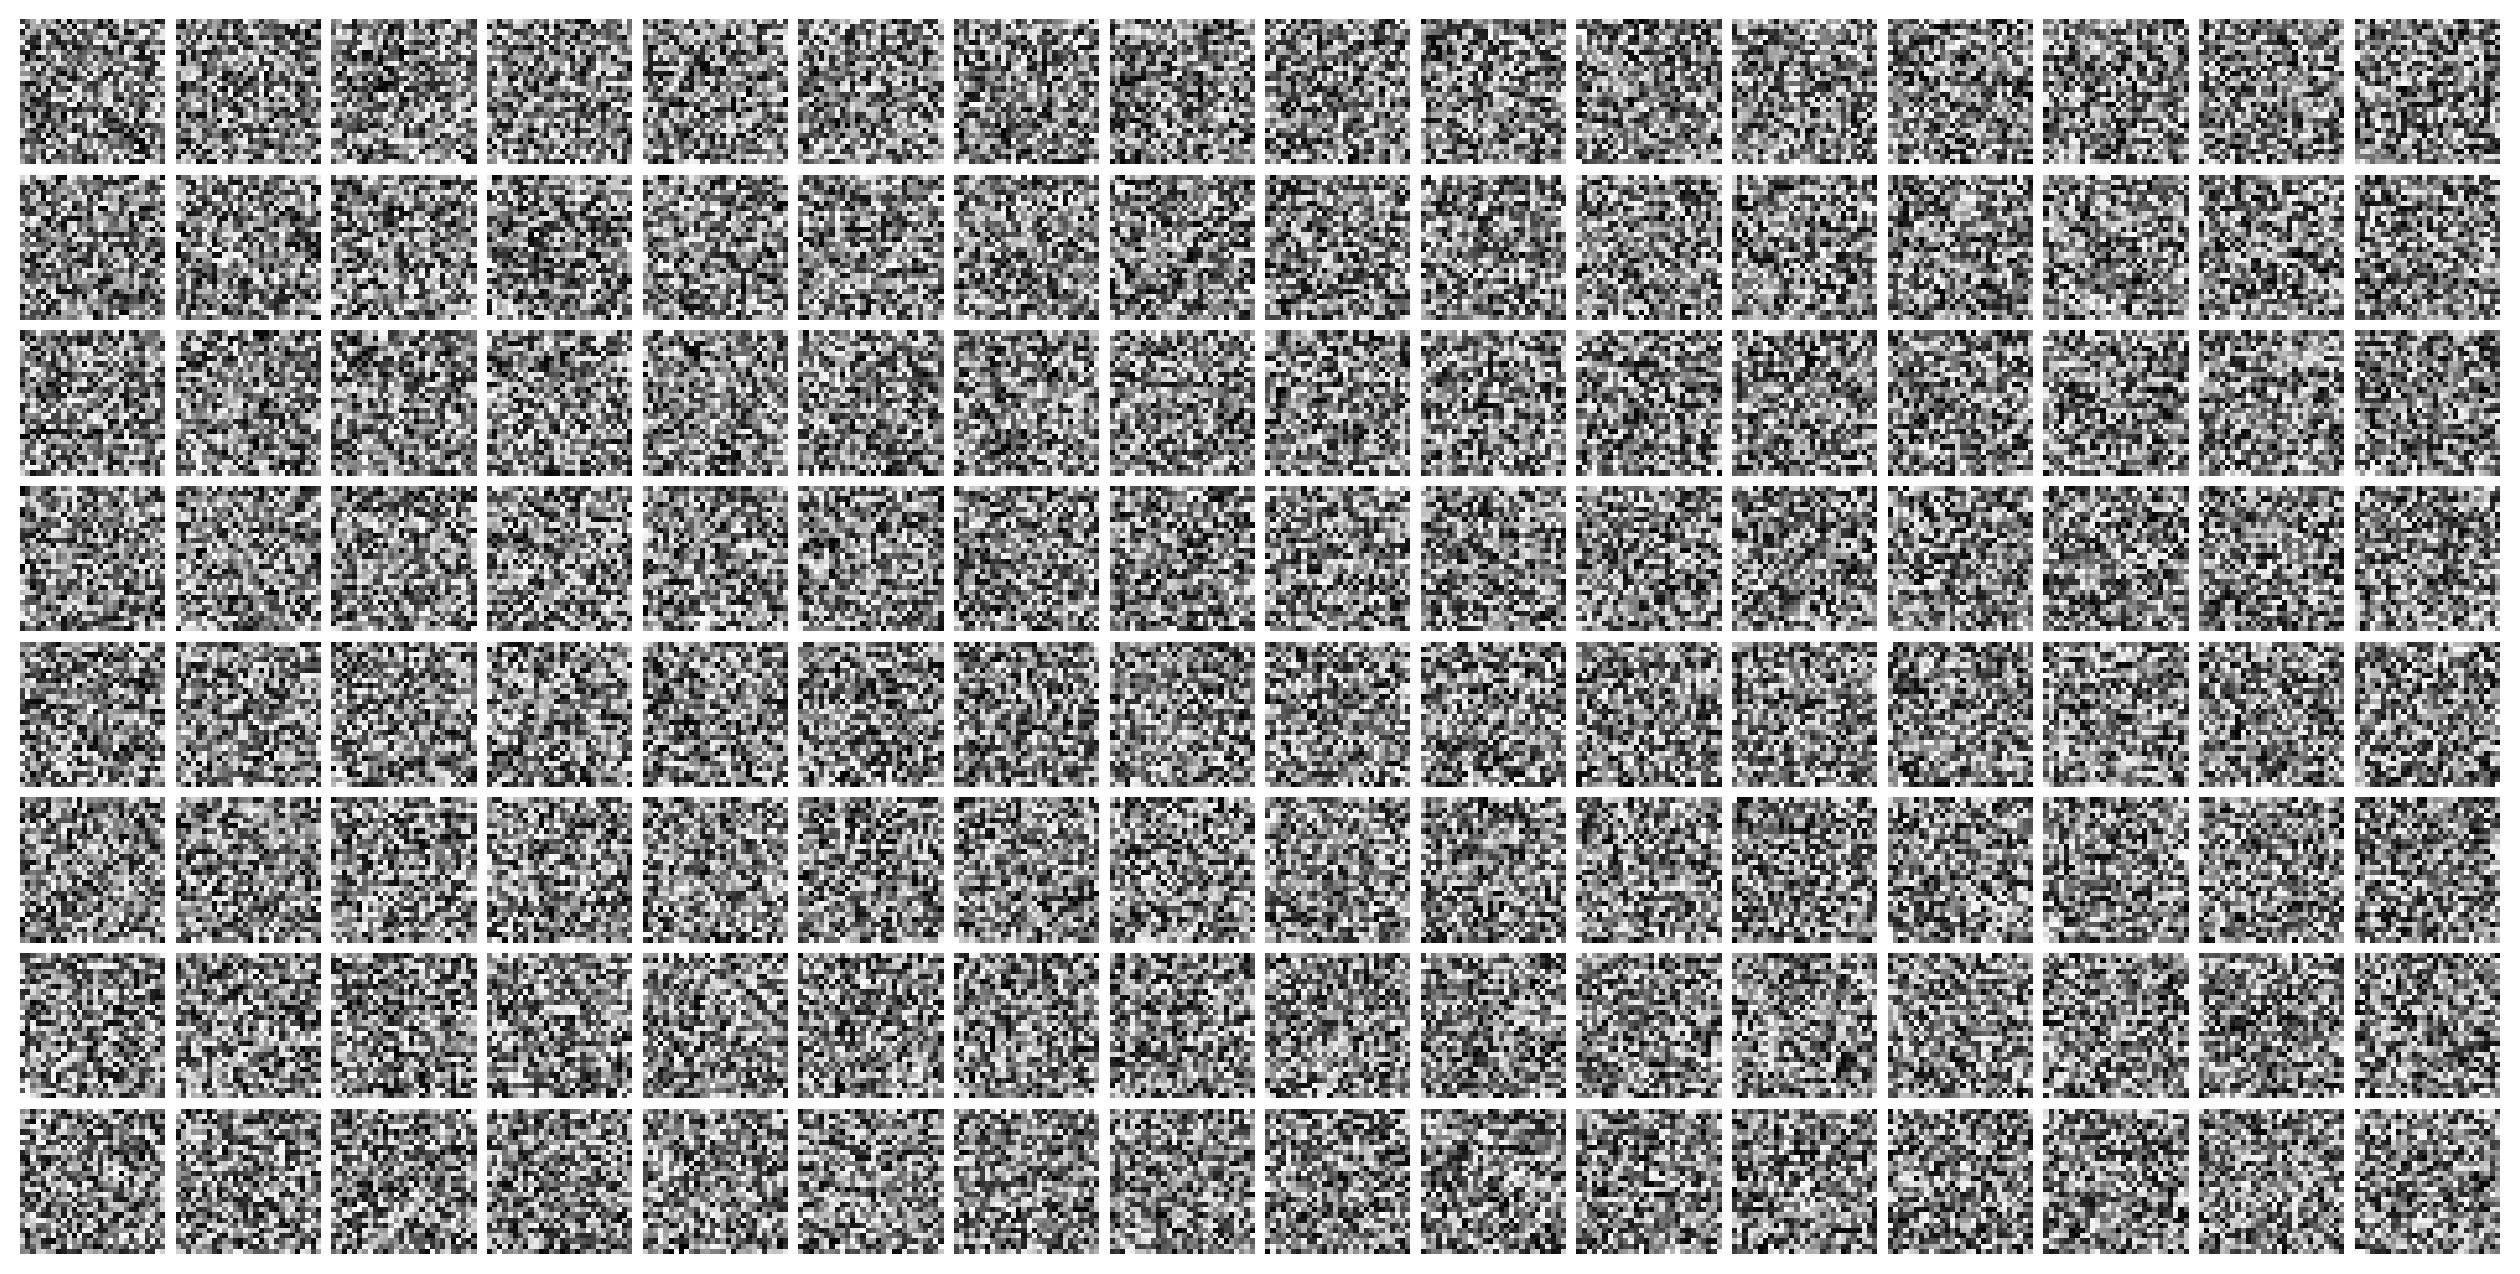

In [10]:
draw_filters(rbm)

In [11]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50


def train_epoch(rbm: RBM, dataset: NDArray):
    batches_limit = dataset.shape[0] / BATCH_SIZE

    for batch_idx, batch in enumerate(chunks(dataset, BATCH_SIZE)):
        cdk(rbm, batch, k=15)
        if batch_idx % round(batches_limit / 50) == 0:
            print("#", end="")


rbm.reset()
for epoch in range(EPOCHS_COUNT):
    print("Epoch {}:".format(epoch + 1), end="\t")

    start_time = time.time()
    train_epoch(rbm, dataset)

    elapsed = time.time() - start_time
    error = reconstuction_error(rbm, monitoring_set)
    print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))

print("Training finished!")

Epoch 1:	#####################################################	elapsed: 3.71s, reconstruction error: 34.05
Epoch 2:	#####################################################	elapsed: 4.23s, reconstruction error: 25.26
Epoch 3:	#####################################################	elapsed: 4.01s, reconstruction error: 22.61
Epoch 4:	#####################################################	elapsed: 4.00s, reconstruction error: 21.27
Epoch 5:	#####################################################	elapsed: 3.76s, reconstruction error: 19.40
Epoch 6:	#####################################################	elapsed: 3.03s, reconstruction error: 18.68
Epoch 7:	#####################################################	elapsed: 7.04s, reconstruction error: 17.70
Epoch 8:	#####################################################	elapsed: 4.18s, reconstruction error: 17.20
Epoch 9:	#####################################################	elapsed: 3.82s, reconstruction error: 16.59
Epoch 10:	###########################

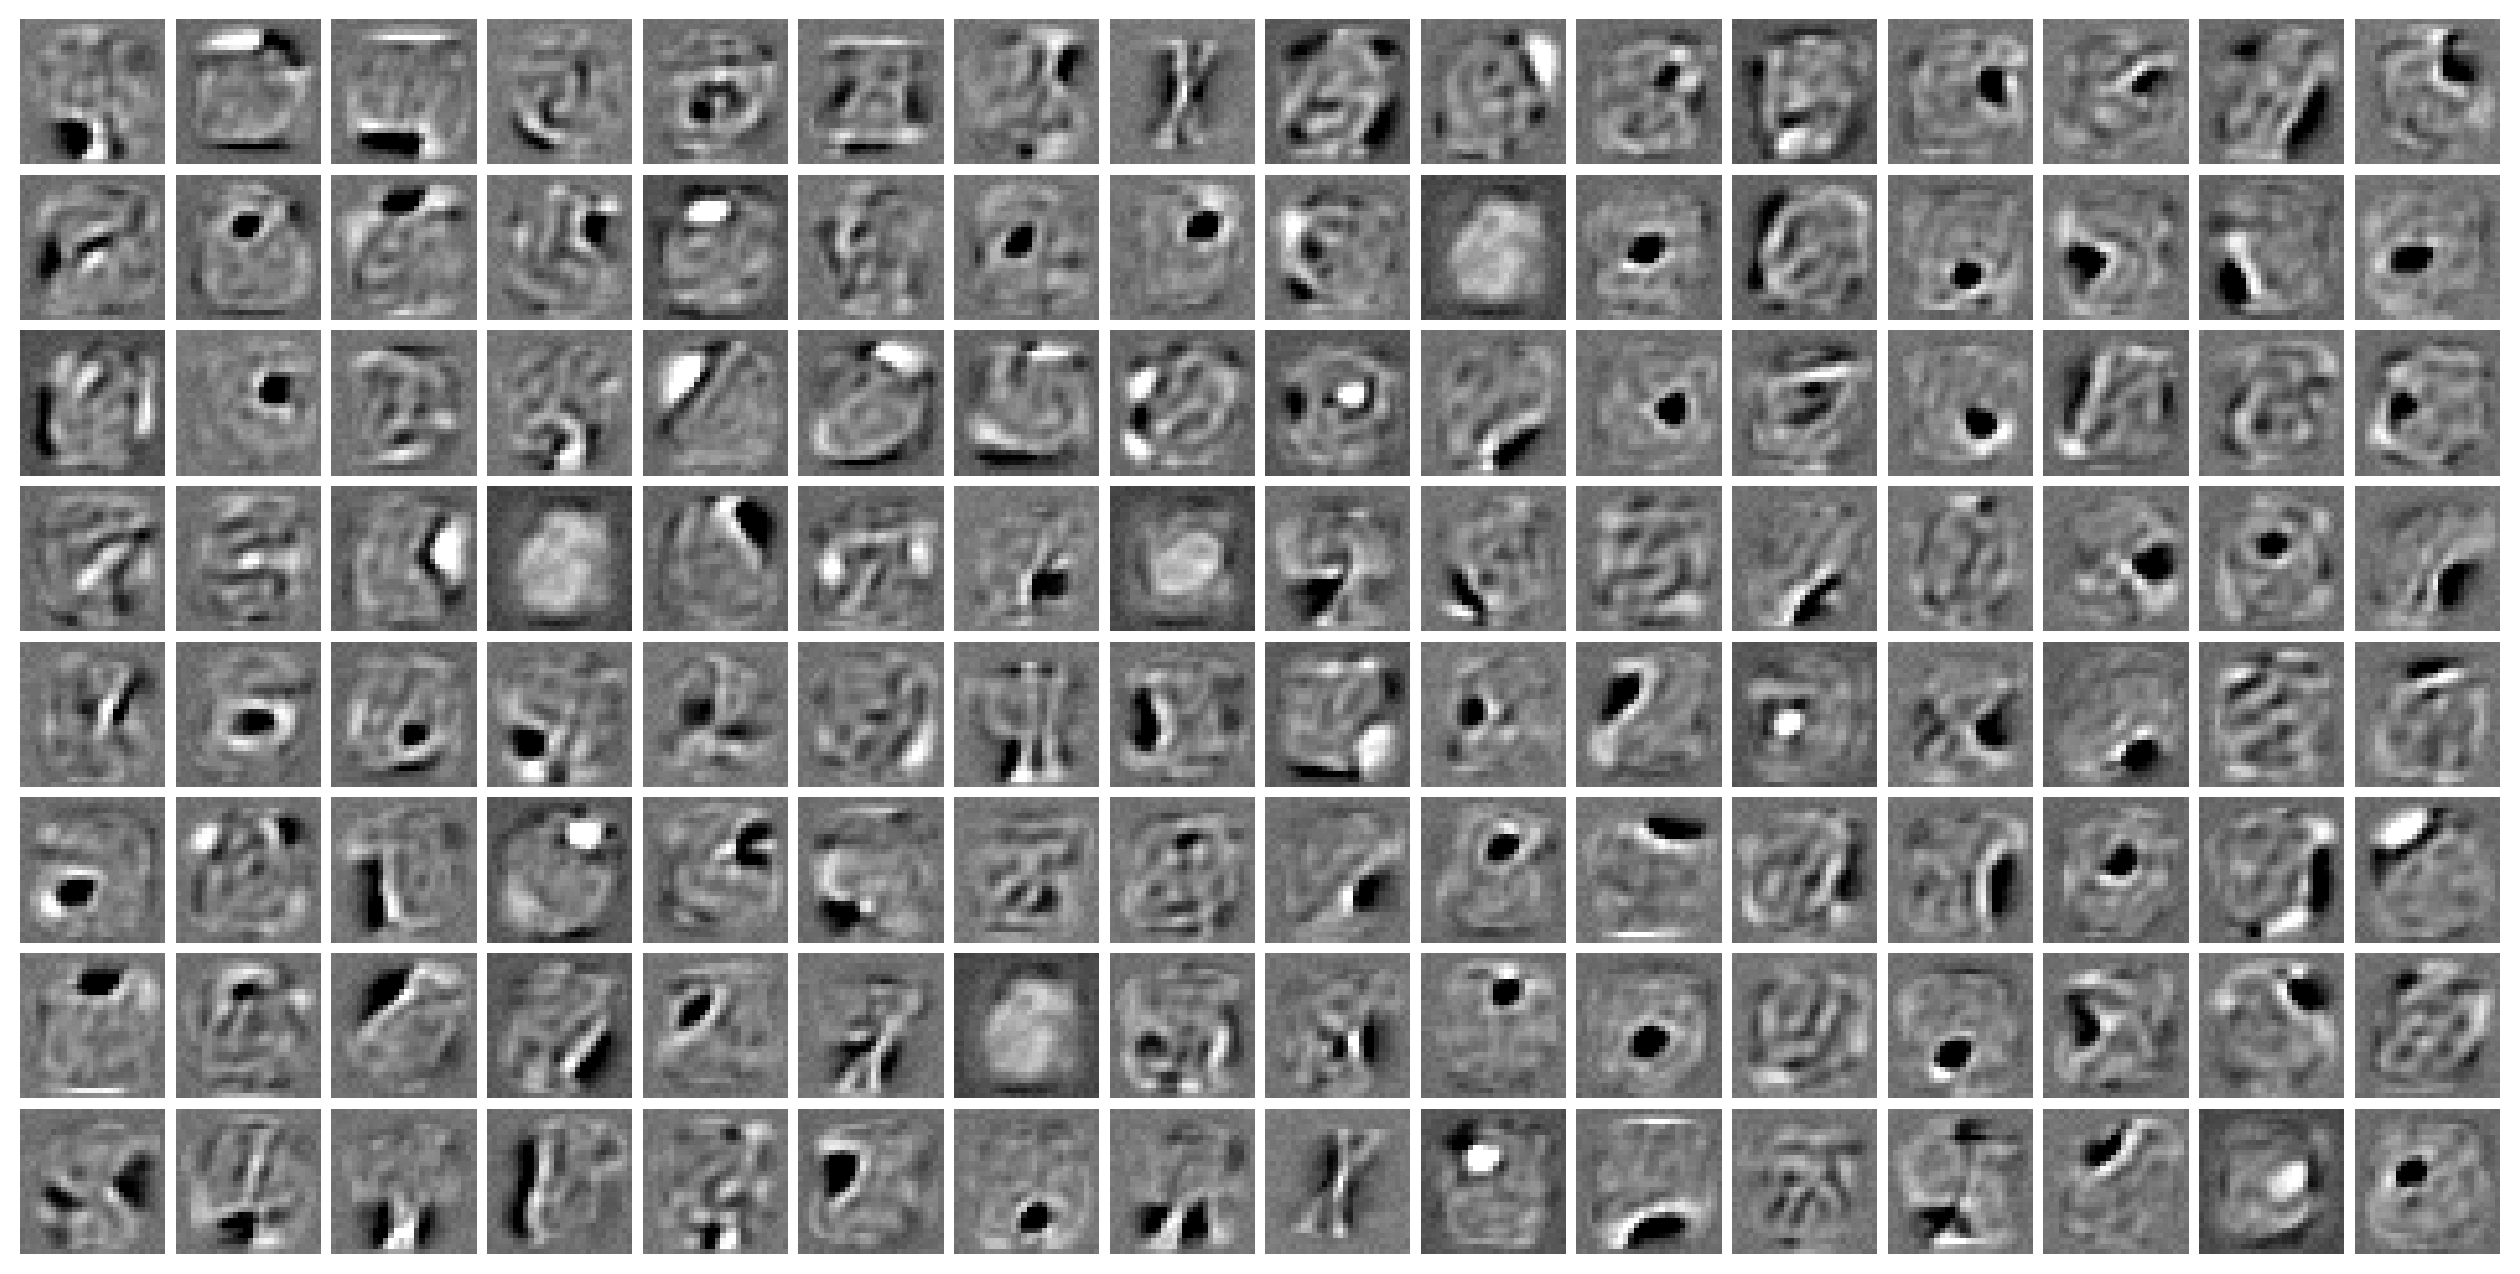

In [12]:
draw_filters(rbm)

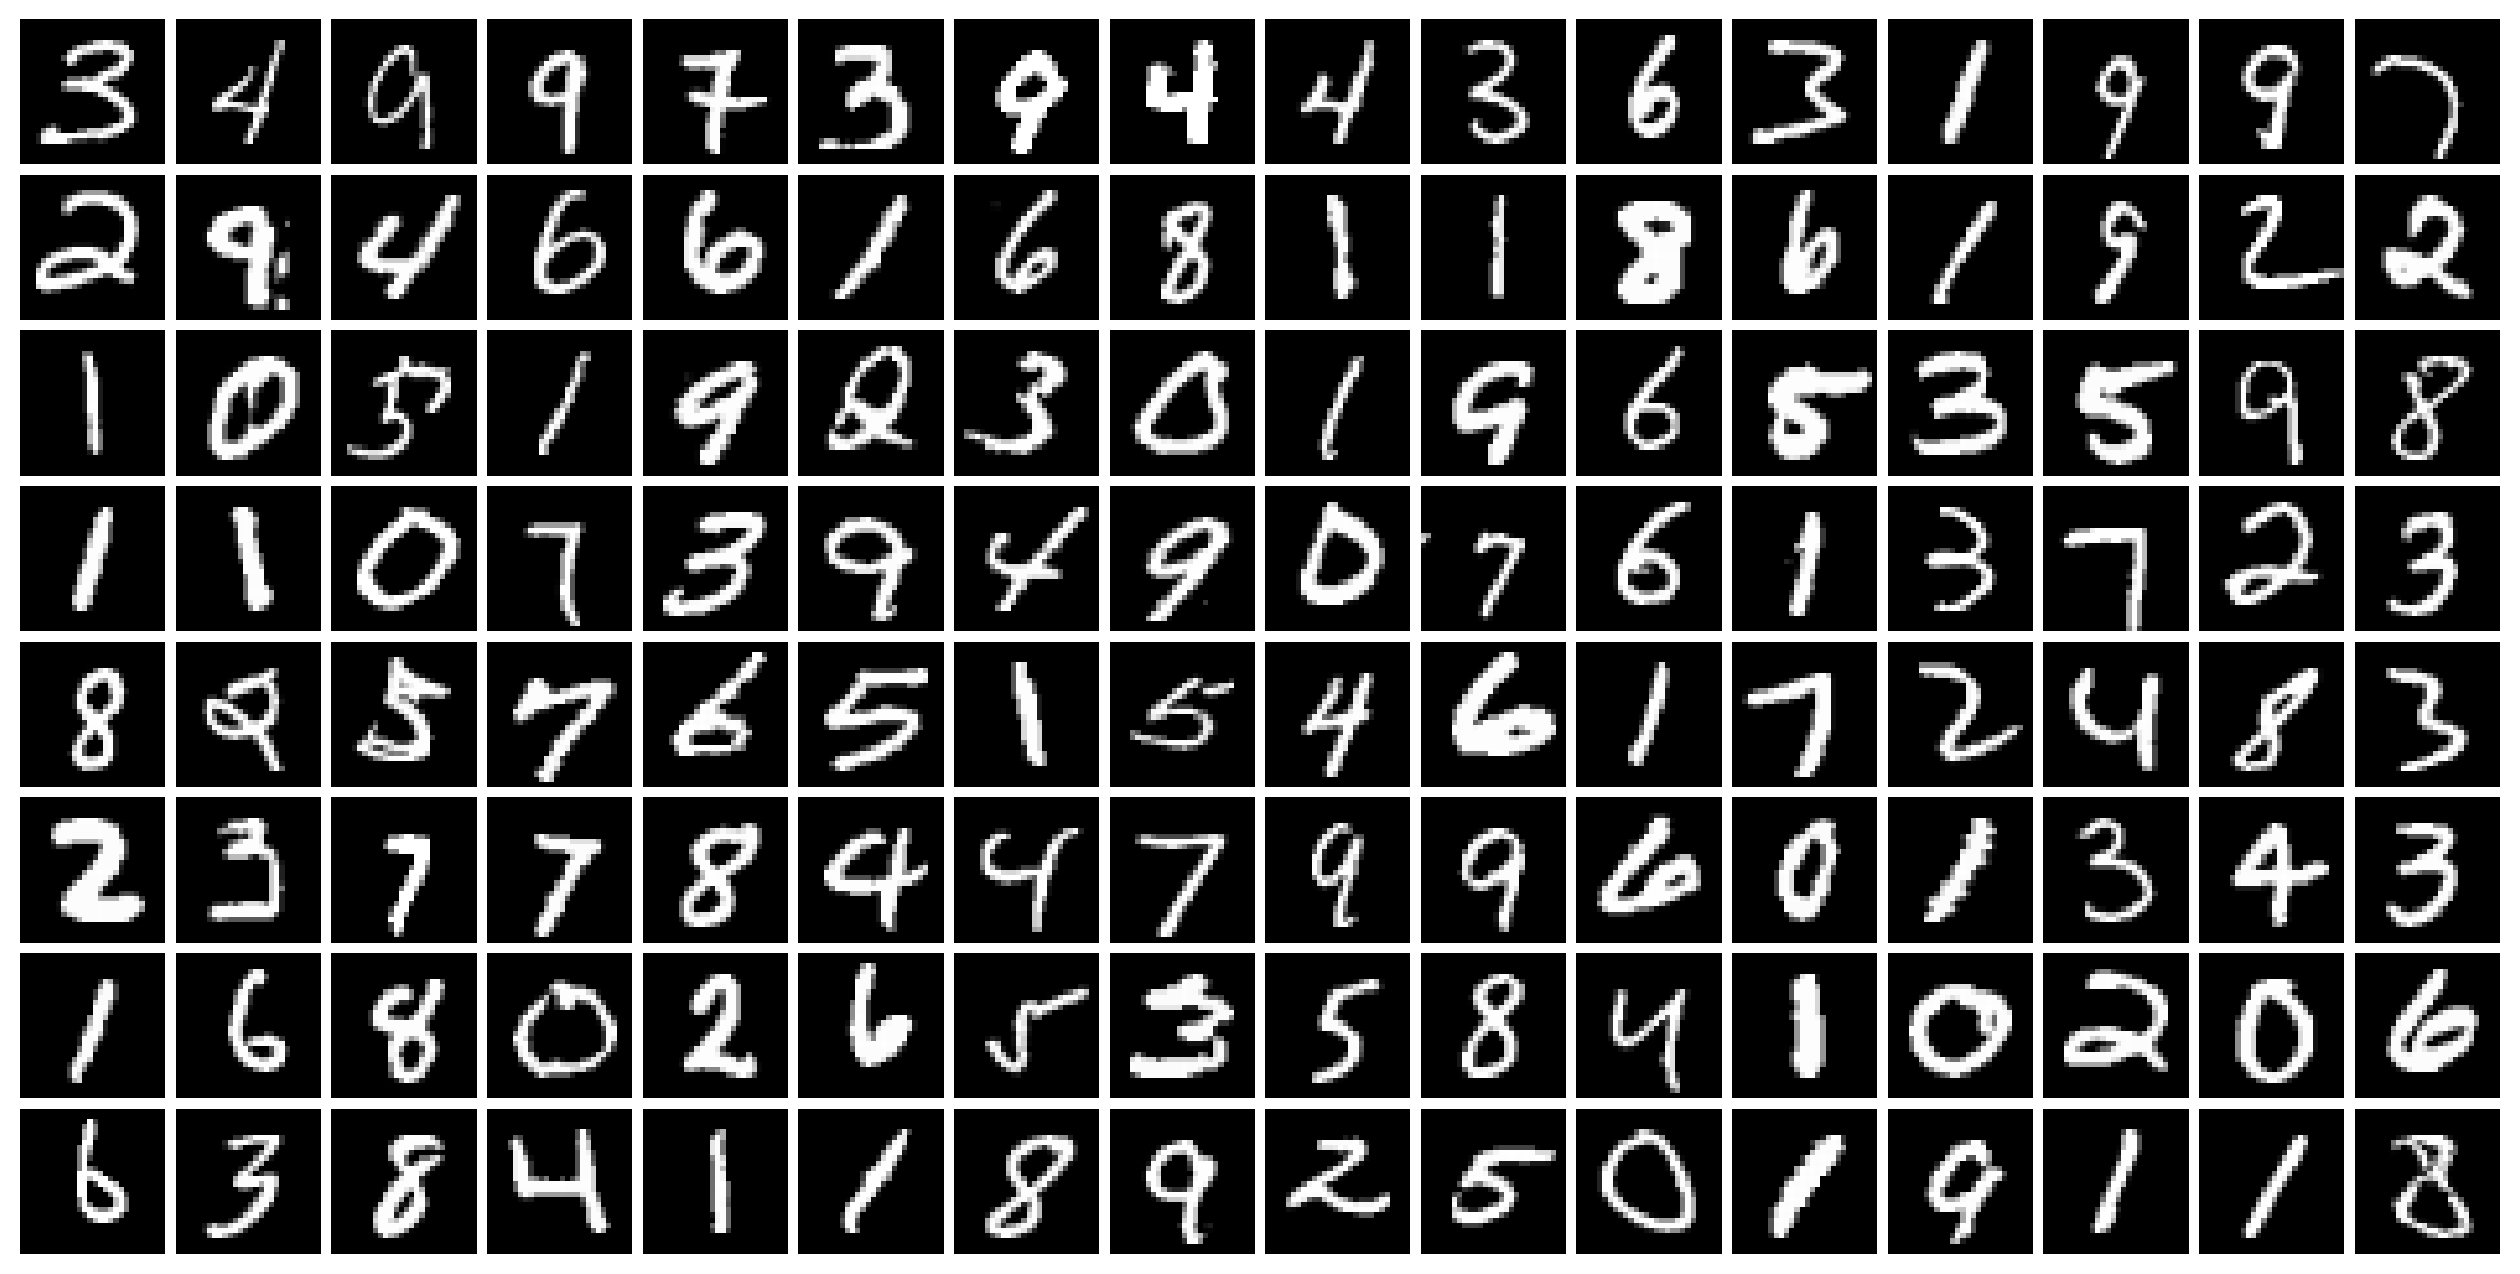

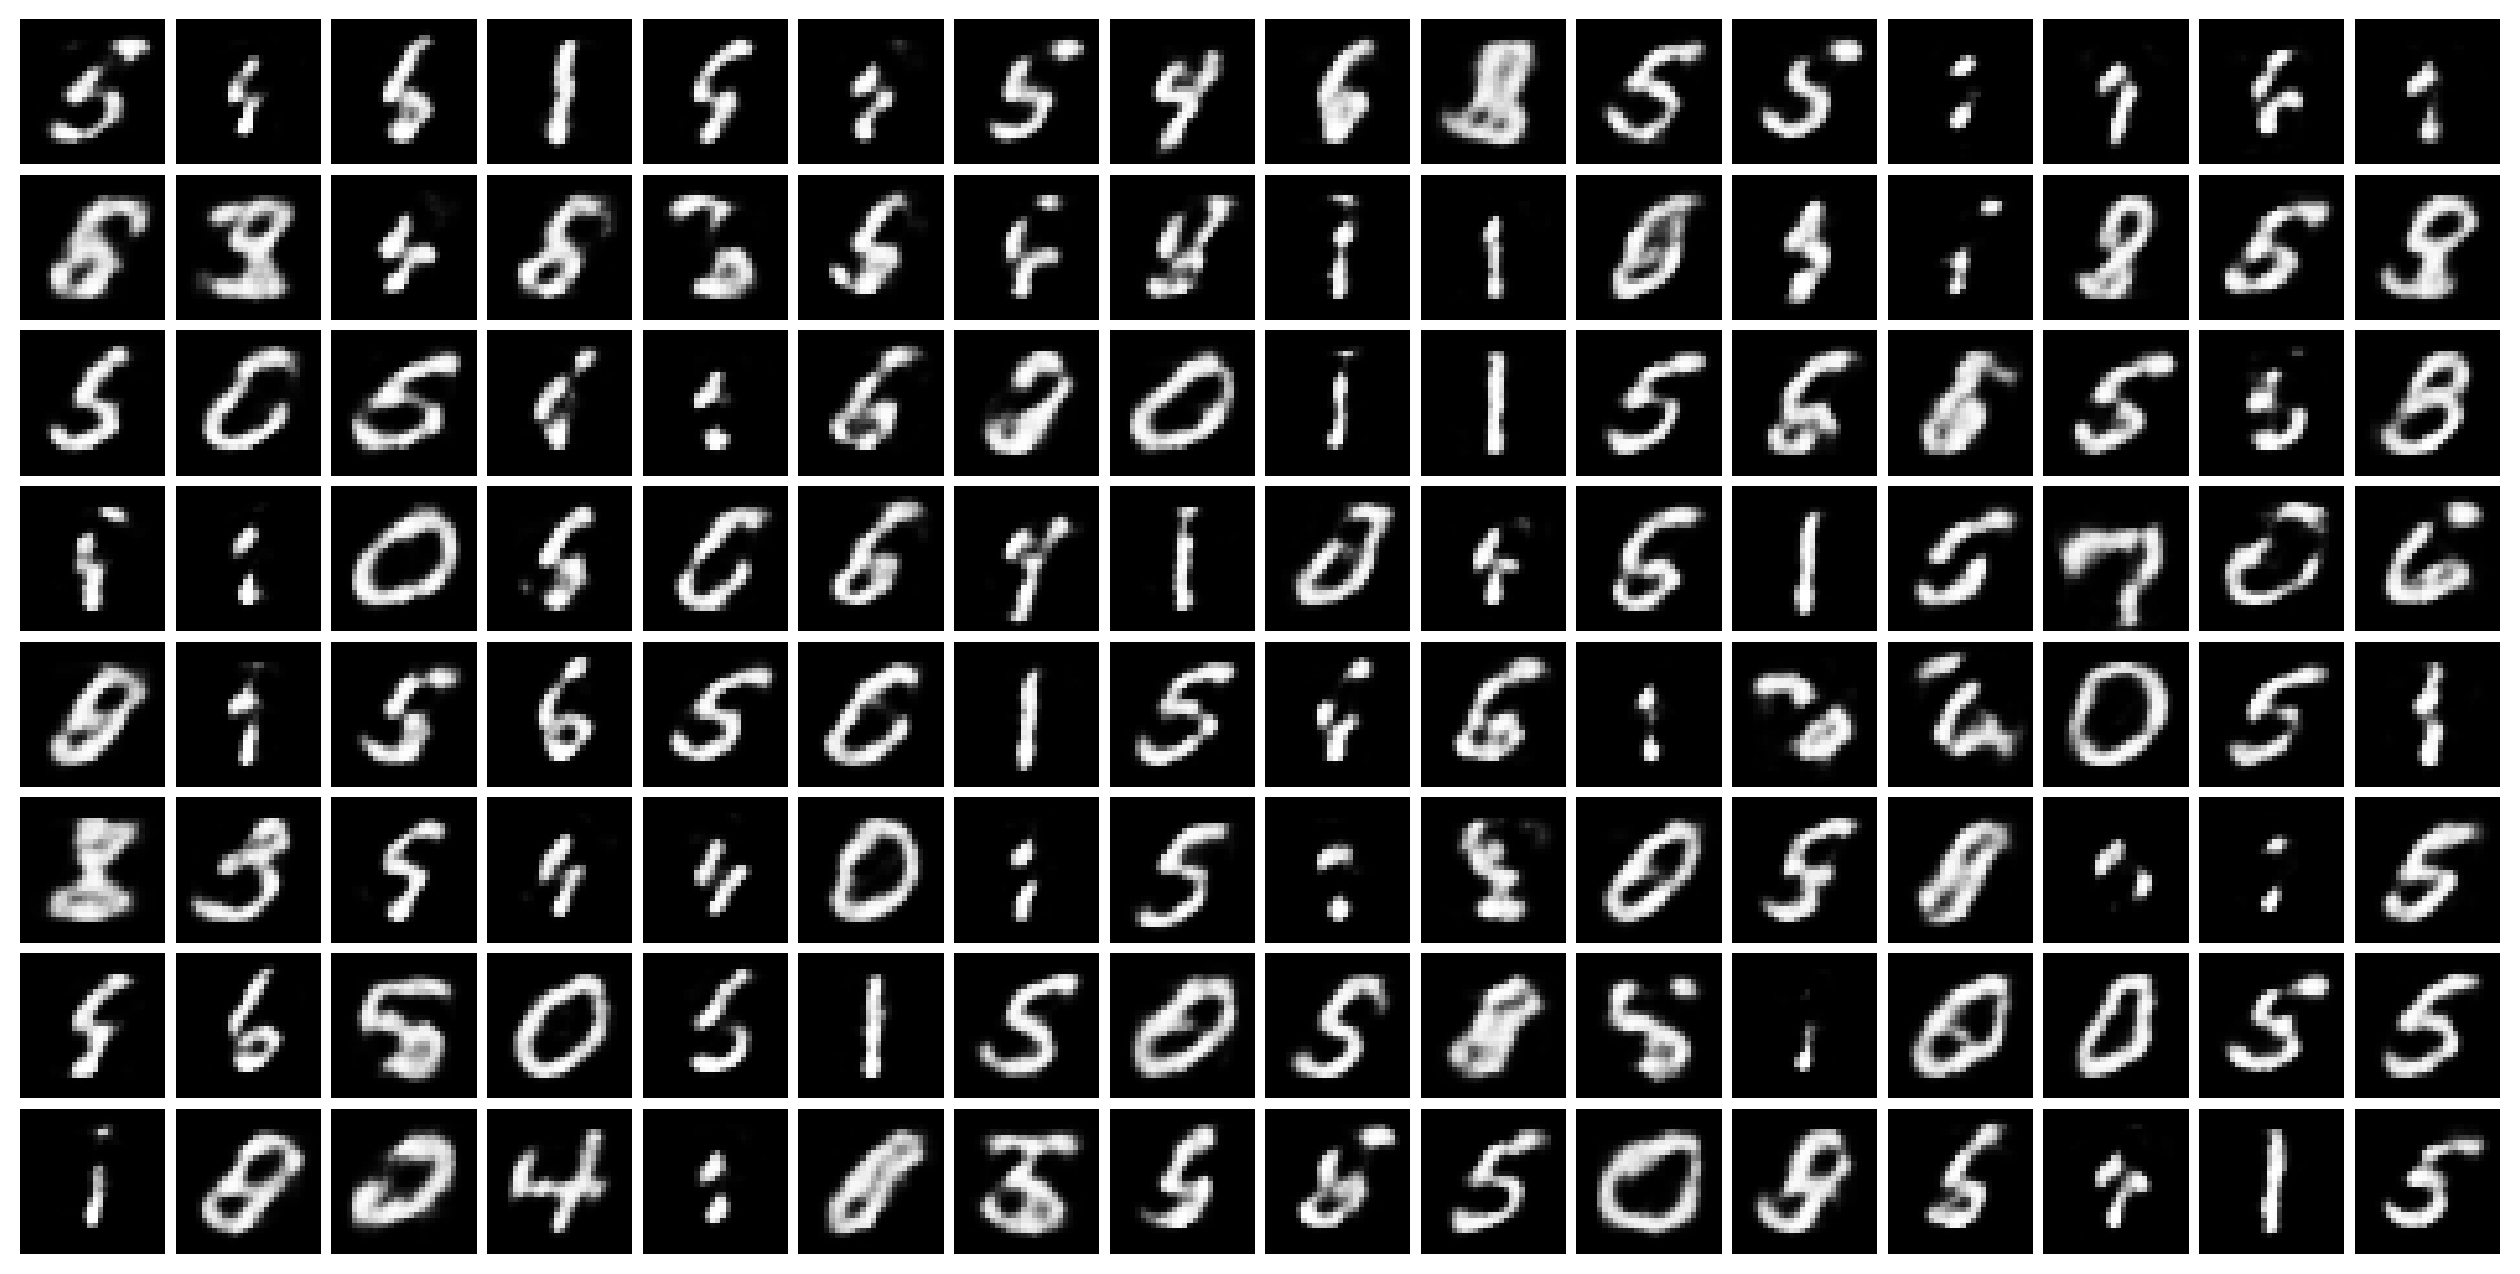

In [20]:
blueprints = monitoring_set[: 8 * 16]
samples = rbm.sample(blueprints, k=200)
tiles(blueprints.reshape(-1, 16, 28, 28))
tiles(samples.reshape(-1, 16, 28, 28))